In [2]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
#pd.options.display.max_rows

In [3]:
kp = pd.read_csv('/Users/caldavis/Documents/GitHub/Capstone-project/Data folder/KenPom Team Metrics.csv')
#kp.head(10)
kp_conf_rat = pd.read_csv('/Users/caldavis/Documents/GitHub/Capstone-project/Data folder/KP_Conf_Ratings.csv')
kp_conf_rat = kp_conf_rat[['Year_Conf', 'Conf_Abb', 'Conf_Rk', 'Conf_Full', 'Conf_Rating']]
kp_conf_rat.head(10)
kp.head(10)

,Season,TeamName,TeamName 2,Tempo,RankTempo,AdjTempo,RankAdjTempo,OE,RankOE,AdjOE,RankAdjOE,DE,RankDE,AdjDE,RankAdjDE,AdjEM,RankAdjEM,seed
0,2019,ABILENE CHRISTIAN,Abilene Christian,66.5681,293,66.0042,254,107.1020,87,103.6250,186,96.7466,43,101.5390,119,2.08626,145,15.0
1,2019,AIR FORCE,Air Force,67.2794,269,66.4070,234,98.7687,274,100.4310,250,105.6820,242,107.2750,238,-6.84432,241,NaN
2,2019,AKRON,Akron,68.4518,207,66.0150,253,99.4248,264,99.7930,257,94.0099,11,93.7022,21,6.09084,107,NaN
3,2019,ALABAMA,Alabama,69.8652,124,68.6333,115,102.4780,185,108.1130,100,102.2220,155,96.6354,50,11.47740,59,NaN
4,2019,ALABAMA A&M,Alabama A&M,67.5600,252,65.4905,282,88.7657,347,86.4818,350,104.8620,219,109.1420,265,-22.66000,344,NaN
5,2019,ALABAMA STATE,Alabama State,68.4214,210,67.0597,198,95.3075,322,94.5978,326,106.1970,250,110.9610,304,-16.36330,329,NaN
6,2019,ALBANY (NY),Albany (NY),66.3119,301,65.7351,268,99.2601,267,98.1540,283,103.2160,176,108.0060,250,-9.85221,277,NaN
7,2019,ALCORN STATE,Alcorn State,67.4020,260,65.6105,277,89.3041,346,88.7838,348,108.2200,288,113.4270,332,-24.64300,349,NaN
8,2019,AMERICAN,American,67.6929,247,66.4126,233,104.5920,141,101.7880,221,100.1360,104,104.9190,186,-3.13075,198,NaN
9,2019,APPALACHIAN STATE,Appalachian State,73.1875,27,71.4297,27,104.6920,138,105.9350,141,110.2310,315,109.5440,274,-3.60901,205,NaN


In [4]:
# All In One Go,

# Prep initial df,
d = pd.read_csv('/Users/caldavis/Documents/GitHub/Capstone-project/Data folder/final_data_by_player_type.csv')
d = pd.merge(d, kp, left_on=['Team', 'year'], right_on=['TeamName', 'Season'], how='left')
d = pd.merge(d, kp, left_on=['Team_n1', 'year'], right_on=['TeamName', 'Season'], how='left')
df = pd.merge(d, kp, left_on=['Team_n1', 'year_n1'], right_on=['TeamName', 'Season'], how='left')
df = pd.merge(df, kp_conf_rat, left_on=['conf_abbr', 'year'], right_on=['Conf_Abb', 'Year_Conf'], how='left')
df = pd.merge(df, kp_conf_rat, left_on=['conf_abbr_n1', 'year'], right_on=['Conf_Abb', 'Year_Conf'], how='left')
df = pd.merge(df, kp_conf_rat, left_on=['conf_abbr_n1', 'year_n1'], right_on=['Conf_Abb', 'Year_Conf'], how='left')
df = df.replace(to_replace='NO IDEA', value=0)
df = df.replace(to_replace='---', value=0)
df = df.fillna(0)

# Convert to Numeric,
df[['games', 'games_started', 'mp_per_g', 'fg_per_g', 'fga_per_g', 'fg_pct', 'fg2_per_g', 'fg2a_per_g', 'fg2_pct', 'fg3_per_g', 'fg3a_per_g', 'fg3_pct', 'ft_per_g', 'fta_per_g', 'ft_pct', 'orb_per_g', 'drb_per_g', 'trb_per_g', 'ast_per_g', 'stl_per_g', 'blk_per_g', 'tov_per_g', 'pf_per_g', 'pts_per_g', 'sos', 'mp', 'fg', 'fga', 'fg2', 'fg2a', 'fg2_pct.1', 'fg3', 'fg3a', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 
    'fg_per_min', 'fga_per_min', 'fg2_per_min', 'fg2a_per_min', 'fg3_per_min', 'fg3a_per_min', 'ft_per_min', 'fta_per_min', 'trb_per_min', 'ast_per_min', 'stl_per_min', 'blk_per_min', 'tov_per_min', 'pf_per_min', 'pts_per_min', 
    'fg_per_poss', 'fga_per_poss', 'fg2_per_poss', 'fg2a_per_poss', 'fg3_per_poss', 'fg3a_per_poss', 'ft_per_poss', 'fta_per_poss', 'trb_per_poss', 'ast_per_poss', 'stl_per_poss', 'blk_per_poss', 'tov_per_poss', 'pf_per_poss', 'pts_per_poss', 'off_rtg', 'def_rtg', 'per', 'ts_pct', 'efg_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_40', 'obpm', 'dbpm', 'bpm', 'year', 'Ht', 'Wt', 'G', 'S', 'X.Min', 'ORtg', 'X.Poss', 'X.Shots', 'games_n1', 'games_started_n1', 'mp_per_g_n1', 'fg_per_g_n1', 'fga_per_g_n1', 'fg_pct_n1', 'fg2_per_g_n1', 'fg2a_per_g_n1', 'fg2_pct_n1', 'fg3_per_g_n1', 'fg3a_per_g_n1', 'fg3_pct_n1', 'ft_per_g_n1', 'fta_per_g_n1', 'ft_pct_n1', 'orb_per_g_n1', 'drb_per_g_n1', 'trb_per_g_n1', 'ast_per_g_n1', 'stl_per_g_n1', 'blk_per_g_n1', 'tov_per_g_n1', 'pf_per_g_n1', 'pts_per_g_n1', 'sos_n1', 'mp_n1', 'fg_n1', 'fga_n1', 'fg2_n1', 'fg2a_n1', 'fg2_pct.1_n1', 'fg3_n1', 'fg3a_n1', 'ft_n1', 'fta_n1', 'orb_n1', 'drb_n1', 'trb_n1', 'ast_n1', 'stl_n1', 'blk_n1', 'tov_n1', 'pf_n1', 'pts_n1', 'fg_per_min_n1', 'fga_per_min_n1', 'fg2_per_min_n1', 'fg2a_per_min_n1', 'fg3_per_min_n1', 'fg3a_per_min_n1', 'ft_per_min_n1', 'fta_per_min_n1', 'trb_per_min_n1', 'ast_per_min_n1', 'stl_per_min_n1', 'blk_per_min_n1', 'tov_per_min_n1', 'pf_per_min_n1', 'pts_per_min_n1', 'fg_per_poss_n1', 'fga_per_poss_n1', 'fg2_per_poss_n1', 'fg2a_per_poss_n1', 'fg3_per_poss_n1', 'fg3a_per_poss_n1', 'ft_per_poss_n1', 'fta_per_poss_n1', 'trb_per_poss_n1', 'ast_per_poss_n1', 'stl_per_poss_n1', 'blk_per_poss_n1', 'tov_per_poss_n1', 'pf_per_poss_n1', 'pts_per_poss_n1', 'off_rtg_n1', 'def_rtg_n1', 'per_n1', 'ts_pct_n1', 'efg_pct_n1', 'fg3a_per_fga_pct_n1', 'fta_per_fga_pct_n1', 'pprod_n1', 'orb_pct_n1', 'drb_pct_n1', 
    'trb_pct_n1', 'ast_pct_n1', 'stl_pct_n1', 'blk_pct_n1', 'tov_pct_n1', 'usg_pct_n1', 'ows_n1', 'dws_n1', 'ws_n1', 'ws_per_40_n1', 'obpm_n1', 'dbpm_n1', 'bpm_n1', 'year_n1', 'Ht_n1', 'Wt_n1', 'G_n1', 'S_n1', 'X.Min_n1', 'ORtg_n1', 'X.Poss_n1', 'X.Shots_n1']] = df[['games', 'games_started', 'mp_per_g', 'fg_per_g', 'fga_per_g', 'fg_pct', 'fg2_per_g', 'fg2a_per_g', 'fg2_pct', 'fg3_per_g', 'fg3a_per_g', 'fg3_pct', 'ft_per_g', 'fta_per_g', 'ft_pct', 'orb_per_g', 'drb_per_g', 'trb_per_g', 'ast_per_g', 'stl_per_g', 'blk_per_g', 'tov_per_g', 'pf_per_g', 'pts_per_g', 'sos', 'mp', 'fg', 'fga', 'fg2', 'fg2a', 'fg2_pct.1', 'fg3', 'fg3a', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'fg_per_min', 'fga_per_min', 'fg2_per_min', 'fg2a_per_min', 'fg3_per_min', 'fg3a_per_min', 'ft_per_min', 'fta_per_min', 'trb_per_min', 'ast_per_min', 'stl_per_min', 'blk_per_min', 'tov_per_min', 'pf_per_min', 'pts_per_min', 'fg_per_poss', 'fga_per_poss', 'fg2_per_poss', 'fg2a_per_poss', 'fg3_per_poss', 'fg3a_per_poss', 'ft_per_poss', 'fta_per_poss', 'trb_per_poss', 'ast_per_poss', 'stl_per_poss', 'blk_per_poss', 'tov_per_poss', 'pf_per_poss', 'pts_per_poss', 'off_rtg', 'def_rtg', 'per', 'ts_pct', 'efg_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_40', 'obpm', 'dbpm', 'bpm', 'year', 'Ht', 'Wt', 'G', 'S', 'X.Min', 'ORtg', 'X.Poss', 'X.Shots', 'games_n1', 'games_started_n1', 'mp_per_g_n1', 'fg_per_g_n1', 'fga_per_g_n1', 'fg_pct_n1', 'fg2_per_g_n1', 'fg2a_per_g_n1', 'fg2_pct_n1', 'fg3_per_g_n1', 'fg3a_per_g_n1', 'fg3_pct_n1', 'ft_per_g_n1', 'fta_per_g_n1', 'ft_pct_n1', 'orb_per_g_n1', 'drb_per_g_n1', 'trb_per_g_n1', 'ast_per_g_n1', 'stl_per_g_n1', 'blk_per_g_n1', 'tov_per_g_n1', 'pf_per_g_n1', 'pts_per_g_n1', 'sos_n1', 'mp_n1', 'fg_n1', 'fga_n1', 'fg2_n1', 'fg2a_n1', 'fg2_pct.1_n1', 'fg3_n1', 'fg3a_n1', 'ft_n1', 'fta_n1', 'orb_n1', 'drb_n1', 'trb_n1', 'ast_n1', 'stl_n1', 'blk_n1', 'tov_n1', 'pf_n1', 'pts_n1', 'fg_per_min_n1', 'fga_per_min_n1', 'fg2_per_min_n1', 'fg2a_per_min_n1', 'fg3_per_min_n1', 'fg3a_per_min_n1', 'ft_per_min_n1', 'fta_per_min_n1', 'trb_per_min_n1', 'ast_per_min_n1', 'stl_per_min_n1', 'blk_per_min_n1', 'tov_per_min_n1', 'pf_per_min_n1', 'pts_per_min_n1', 'fg_per_poss_n1', 'fga_per_poss_n1', 'fg2_per_poss_n1', 'fg2a_per_poss_n1', 'fg3_per_poss_n1', 'fg3a_per_poss_n1', 'ft_per_poss_n1', 'fta_per_poss_n1', 'trb_per_poss_n1', 'ast_per_poss_n1', 'stl_per_poss_n1', 'blk_per_poss_n1', 'tov_per_poss_n1', 'pf_per_poss_n1', 'pts_per_poss_n1', 'off_rtg_n1', 'def_rtg_n1', 'per_n1', 'ts_pct_n1', 'efg_pct_n1', 'fg3a_per_fga_pct_n1', 'fta_per_fga_pct_n1', 'pprod_n1', 'orb_pct_n1', 'drb_pct_n1', 'trb_pct_n1', 'ast_pct_n1', 'stl_pct_n1', 'blk_pct_n1', 'tov_pct_n1', 'usg_pct_n1', 'ows_n1', 'dws_n1', 'ws_n1', 'ws_per_40_n1', 'obpm_n1', 'dbpm_n1', 'bpm_n1', 'year_n1', 'Ht_n1', 'Wt_n1', 'G_n1', 'S_n1', 'X.Min_n1', 'ORtg_n1', 'X.Poss_n1', 'X.Shots_n1']].apply(pd.to_numeric, errors='ignore')

# Add Contributions,
conditions = [(df['X.Poss_n1']>=28.0) & (df['X.Min_n1']>10.0), (df['X.Poss_n1']>=24.0)& (df['X.Min_n1']>10.0), 
              (df['X.Poss_n1']>=20.0) & (df['X.Min_n1']>10.0), (df['X.Poss_n1']>=16) & (df['X.Min_n1']>10.0),
            (df['X.Poss_n1']>=12.0) & (df['X.Min_n1']>10.0), (df['X.Poss_n1']<12) & (df['X.Min_n1']>10.0), 
            (df['X.Min_n1']<10)]
#(df['X.Min_n1']<10),,
#values = ['Go-To Guy', 'Major Contributor', 'Significant Contributor', 'Role Players', 'Limited Role', 'Nearly Invisible', 'Bench Warmer'],
values = [0, 1, 2, 3, 4, 5, 6]
df['Contribution_n1'] = np.select(conditions, values)

# Add Year in School KP,
year_cond = [(df['Yr_n1']=='Fr'), (df['Yr_n1']=='So'),
            (df['Yr_n1']=='Jr'), (df['Yr_n1']=='Sr')]
year_val = [1, 2, 3, 4]
df['Class'] = np.select(year_cond, year_val)

# Add Ht. Categories,
ht_cond = [(df['Ht']<=74), (df['Ht']>74) & (df['Ht']<=76), (df['Ht']>76) & (df['Ht']<=78),
   (df['Ht']>78) & (df['Ht']<=80), (df['Ht']>80)]

ht_val = [1, 2, 3, 4, 5]
df['Pos_Ht'] = np.select(ht_cond, ht_val)
#df[‘column’] =( df[‘column’] – df[‘column’].mean() ) / df[‘column’].std(),

    
# Additional Features + Model Prep,
df = df.drop(df[(df['games']<=13) & (df['games_started']/df['games']>0.1)].index)
df = df.drop(df[(df['games_n1']<=13) & (df['games_started_n1']/df['games_n1']>0.1)].index)
#df = df.drop(df[(df['games']<=13) & (df['games_started']/df['games']>0.1)].index)
#df = df.drop(df[(df['games_n1']<=13) & (df['games_started_n1']/df['games_n1']>0.1)].index)


df = df.drop(df.loc[((df['games']>39) & (df['year']==2023)) | ((df['games_n1']>39) & (df['year_n1']==2023)) | 
   ((df['games']>40) & (df['year']==2022)) | ((df['games_n1']>40) & (df['year_n1']==2022)) | 
   ((df['games']>33) & (df['year']==2021)) | ((df['games_n1']>33) & (df['year_n1']==2021)) | 
   ((df['games']>35) & (df['year']==2020)) | ((df['games_n1']>35) & (df['year_n1']==2020)) | 
   ((df['games']>40) & (df['year']==2019)) | ((df['games_n1']>40) & (df['year_n1']==2019)) |
   (df['year']==0)]['Player.Name'].index)
idx = df.groupby(['Team', 'year'])['games'].max()
a = pd.DataFrame(idx)
ab = a.reset_index()
ab.columns = ['Team_max', 'year_max', 'games_max']
df = pd.merge(df, ab, left_on=['Team', 'year'], right_on=['Team_max', 'year_max'], how='left')
idx2 = df.groupby(['Team_n1', 'year_n1'])['games_n1'].max()
a2 = pd.DataFrame(idx2)
ab2 = a2.reset_index()
ab2.columns = ['Team_max', 'year_max', 'games_max']
df = pd.merge(df, ab2, left_on=['Team_n1', 'year_n1'], right_on=['Team_max', 'year_max'], how='left')
df.columns
tt = df[['Player.Name', 'Team', 'year', 'games_max_x', 'Team_n1', 'year_n1', 'games_max_y', 'games_n1']]
tt[tt['Player.Name']=='tevin-mack-1']
#df = df.drop(df[(df['games']<=0.1*df['games_max_x'])].index)
#df = df.drop(df[(df['games_n1']<=0.1*df['games_max_y'])].index)
#df = df.drop(df.loc[(df['games_max_x']<15)].index)
#df = df.drop(df.loc[(df['games_max_y']<15)].index)

#df = df.drop(df.loc[(df['year']==2020) | (df['year_n1']==2020)].index)
df = df.drop(df[(df['X.Min_n1']<=10)].index)
df = df.drop(df[(df['X.Min']<=10)].index)
df['Year_dif'] = df['year_n1']-df['year']
df['Team_AdjEM_dif'] = df['AdjEM_y']-df['AdjEM_x']
df['KP_Rk_Dif'] = df['RankAdjEM_y']-df['RankAdjEM_x']
df['KP_Conf_Dif'] = df['Conf_Rating_y']-df['Conf_Rating_x']
df['Calc A'] = df['X.Min']*(df['ws']-min(df['ws']))
df['Calc A2'] = df['X.Min']*df['bpm']
# df['Calc A2'] = df['bpm']/(1-df['X.Min'])
df['Calc A3'] = df['X.Min']*df['ORtg']
df['Calc A2_n1'] = df['X.Min_n1']*df['bpm_n1']
# df['Calc A2_n1'] = df['bpm_n1']/(1-df['X.Min_n1'])
df['Calc A_n1'] =df['X.Min_n1']*(df['ws_n1']-min(df['ws_n1']))
df['Calc A3_n1'] = df['X.Min_n1']*df['ORtg_n1']
df['Calc B'] = (df['stl_per_poss']+df['blk_per_poss']+df['DR.'])*df['X.Min']
df['Calc B_n1'] = (df['stl_per_poss_n1']+df['blk_per_poss_n1']+df['DR._n1'])*df['X.Min_n1']
df['Calc C']=(df['off_rtg']-df['def_rtg'])*df['X.Min']
df['Calc C_n1']=(df['off_rtg_n1']-df['def_rtg_n1'])*df['X.Min_n1']
df['Calc Overall A'] = df['Calc A'] + df['Calc B']
df['Calc Overall A2'] = df['Calc A2'] + df['Calc B']
df['Calc Overall A3'] = df['Calc A3'] + df['Calc B']
df['Calc Overall A_n1'] = df['Calc A_n1'] + df['Calc B_n1']
df['Calc Overall A2_n1'] = df['Calc A2_n1'] + df['Calc B_n1']
df['Calc Overall A3_n1'] = df['Calc A3_n1'] + df['Calc B_n1']

# Calc_A_n1_cond = [(df['Calc A_n1']<=340), (df['Calc A_n1']>340) & (df['Calc A_n1']<=664), (df['Calc A_n1']>664) & (df['Calc A_n1']<=1010),,
#            (df['Calc A_n1']>1010) & (df['Calc A_n1']<=1415), (df['Calc A_n1']>1415)],

# Calc_A_n1_val = [0, 1, 2, 3, 4],
# df['Calc_A_Contr'] = np.select(Calc_A_n1_cond, Calc_A_n1_val),
column_to_test = 'Calc A2_n1'
# Calc_overall_n1_cond = [(df[column_to_test]<=(df[column_to_test].max()-df[column_to_test].min())/10+df[column_to_test].min()), ,
#                         (df[column_to_test]>(df[column_to_test].max()-df[column_to_test].min())/10+df[column_to_test].min()) & (df[column_to_test]<=(df[column_to_test].max()-df[column_to_test].min())/2+df[column_to_test].min()), ,
#                         (df[column_to_test]>(df[column_to_test].max()-df[column_to_test].min())/2+df[column_to_test].min()) & (df[column_to_test]<=8*(df[column_to_test].max()-df[column_to_test].min())/10+df[column_to_test].min()),,
#                         (df[column_to_test]>8*(df[column_to_test].max()-df[column_to_test].min())/10+df[column_to_test].min())],

                        # & (df[column_to_test]<=4*(df[column_to_test].max()-df[column_to_test].min())/6+df[column_to_test].min()), ,
                        #(df[column_to_test]>4*(df[column_to_test].max()-df[column_to_test].min())/6+df[column_to_test].min())],
# Calc_overall_n1_cond = [(df[column_to_test]<=df[column_to_test].quantile(0.1)),
#                         (df[column_to_test]>df[column_to_test].quantile(0.1)) & (df[column_to_test]<=df[column_to_test].quantile(0.4)),
#                         (df[column_to_test]>df[column_to_test].quantile(0.4)) & (df[column_to_test]<=df[column_to_test].quantile(0.88)),
#                         (df[column_to_test]>df[column_to_test].quantile(0.88))]
Calc_overall_n1_cond = [(df[column_to_test]<=df[column_to_test].quantile(0.5)),
                        (df[column_to_test]>df[column_to_test].quantile(0.5)) & (df[column_to_test]<=df[column_to_test].quantile(0.88)),
                        (df[column_to_test]>df[column_to_test].quantile(0.88))]
Calc_A_n1_val = [2, 1, 0]
#Calc_A_n1_val = [3, 2, 1, 0]
df['Calc_Overall_n1_Contr'] = np.select(Calc_overall_n1_cond, Calc_A_n1_val)

/var/folders/cq/16hkxgp926d466c0g9jzx2900000gq/T/ipykernel_57688/1592445520.py:4: DtypeWarning: Columns (13,16,38,144,147,169) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv('/Users/caldavis/Documents/GitHub/Capstone-project/Data folder/final_data_by_player_type.csv')
/var/folders/cq/16hkxgp926d466c0g9jzx2900000gq/T/ipykernel_57688/1592445520.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Contribution_n1'] = np.select(conditions, values)
/var/folders/cq/16hkxgp926d466c0g9jzx2900000gq/T/ipykernel_57688/1592445520.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usi

In [5]:
pd.set_option('display.max_columns', None)
#df[['X.Poss_n1', 'X.Min_n1','Contribution_n1']].head(20)

In [6]:
#df[['Team', 'year', 'games_max']].sort_values('games_max')


In [7]:
from sklearn.preprocessing import StandardScaler
# feature1 = ['bpm', 'Calc A2', 'ws', 'dws', 'ows', 'Calc Overall', 'KP_Conf_Dif', 'X.Poss', 
#                    'Year_dif',  'Calc A', 'Calc B', 
#                  'DR.',  'Team_AdjEM_dif', 'player_type',
#                  'Class', 'player_type', 'Pos_Ht', 'Calc C', 'off_rtg', 'def_rtg', 'ORtg']
feature1 = ['games', 'games_started', 'mp_per_g', 'fg_per_g', 'fga_per_g', 'fg_pct', 'fg2_per_g', 'fg2a_per_g', 
            'fg2_pct', 'fg3_per_g', 'fg3a_per_g', 'fg3_pct', 'ft_per_g', 'fta_per_g', 'ft_pct', 'orb_per_g', 
            'drb_per_g', 'trb_per_g', 'ast_per_g', 'stl_per_g', 'blk_per_g', 'tov_per_g', 'pf_per_g', 'pts_per_g', 
            'sos', 'mp', 'fg', 'fga', 'fg2', 'fg2a', 'fg2_pct.1', 'fg3', 'fg3a', 'ft', 'fta', 'orb', 'drb', 'trb', 
            'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 
    'fg_per_min', 'fga_per_min', 'fg2_per_min', 'fg2a_per_min', 'fg3_per_min', 'fg3a_per_min', 'ft_per_min', 
    'fta_per_min', 'trb_per_min', 'ast_per_min', 'stl_per_min', 'blk_per_min', 'tov_per_min', 'pf_per_min', 
    'pts_per_min', 
    'fg_per_poss', 'fga_per_poss', 'fg2_per_poss', 'fg2a_per_poss', 'fg3_per_poss', 'fg3a_per_poss', 
    'ft_per_poss', 'fta_per_poss', 'trb_per_poss', 'ast_per_poss', 'stl_per_poss', 'blk_per_poss', 'tov_per_poss', 
    'pf_per_poss', 'pts_per_poss', 'off_rtg', 'def_rtg', 'per', 'ts_pct', 'efg_pct', 'fg3a_per_fga_pct', 
    'fta_per_fga_pct', 'pprod', 'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 
    'usg_pct', 'ows', 'dws', 'ws', 'ws_per_40', 'obpm', 'dbpm', 'bpm', 'year', 'Ht', 'Wt', 'G', 'S', 'X.Min', 'ORtg', 
    'X.Poss', 'X.Shots']
# , 'X.Min', 'obpm', 'dbpm
# , 'Calc_Overall_n1_Contr'
y_try = df[['Calc_Overall_n1_Contr']]
#y_try = df[['Contribution_n1']]
df_temp = df
#print(df_temp.columns)
df_temp = df_temp.drop(['Calc_Overall_n1_Contr'], axis=1)
#df_temp = df_temp.drop(['Contribution_n1'], axis=1)
x_try = df_temp.loc[:, feature1].values
#y_try = df.loc[:,['target']].values

x_try = StandardScaler().fit_transform(x_try)

from sklearn.decomposition import PCA

pca = PCA(n_components=0.9, whiten=True)

principalComponents = pca.fit_transform(x_try)

principalDf = pd.DataFrame(data = principalComponents)
#principalDf = pd.concat([principalDf, df_temp['player_type']], axis=1)
principalDf.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.397556,-1.501826,0.856773,-1.091962,-0.611984,-0.515041,0.581096,-0.857048,0.670695,-0.355438,0.514340,0.624504,-0.115497,-0.265782,0.956901
1,0.394302,0.001310,1.996281,-0.256759,-0.272002,-0.296238,0.584225,1.058011,0.886437,0.039788,0.837545,-0.263403,-1.095264,0.121855,-1.364184
2,1.768146,0.403011,0.821551,-0.517436,0.443702,-0.194232,0.256642,0.476340,-0.163543,0.141001,0.380372,-1.232468,0.603006,0.952490,-0.946237
3,-0.815188,-0.947480,0.471417,1.486718,-0.129868,0.241133,-1.348276,0.812748,0.561250,-1.102158,-0.852658,0.761093,1.386914,0.173428,0.877704
4,-0.323258,-1.104143,1.700520,0.878813,-0.114399,0.065836,-1.167396,-0.563423,-0.365821,0.440141,-0.124269,-0.595734,-0.470709,-1.052653,0.873952
5,-0.559986,1.008824,1.806610,-1.956993,0.351669,-1.163718,1.912261,0.401696,-0.817700,-0.940486,-0.611547,-1.216058,-0.926933,1.117003,0.616930
6,-0.771802,1.386858,1.750458,-0.251686,0.771440,-0.374920,-1.566231,0.581901,-0.545697,-1.425163,0.378850,0.084438,-0.569097,-0.133753,-0.126858
7,-0.377710,-0.734362,-0.786208,0.935848,-0.486767,-0.214476,0.004622,-1.999357,0.520505,0.061032,0.544734,0.451997,-1.171161,-0.139257,1.473496
8,0.038772,-1.176539,-1.137109,1.125528,0.212118,-0.394743,0.321963,-2.008034,-0.137453,1.089064,0.722134,0.317418,-0.826583,0.640738,1.504991
9,0.125112,-1.108954,-2.215892,1.056162,-0.083972,-0.047009,0.582541,-2.028558,-0.552311,1.636719,-0.551451,2.037741,0.760304,0.649349,0.104058


In [8]:
# loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PCA10'], index=feature1)
# pd.set_option('display.max_rows', None)
# loadings

In [9]:
df[column_to_test].quantile(0.09)

-223.018

In [10]:
df[df['Calc A2_n1']<=-250].sort_values('pts_per_g')

,Unnamed: 0,player_type,Team,Team_n1,Unnamed..0_x,Player.Name,season,conf_abbr,games,games_started,mp_per_g,fg_per_g,fga_per_g,fg_pct,fg2_per_g,fg2a_per_g,fg2_pct,fg3_per_g,fg3a_per_g,fg3_pct,ft_per_g,fta_per_g,ft_pct,orb_per_g,drb_per_g,trb_per_g,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g,sos,mp,fg,fga,fg2,fg2a,fg2_pct.1,fg3,fg3a,ft,fta,orb,drb,trb,ast,stl,blk,tov,pf,pts,fg_per_min,fga_per_min,fg2_per_min,fg2a_per_min,fg3_per_min,fg3a_per_min,ft_per_min,fta_per_min,trb_per_min,ast_per_min,stl_per_min,blk_per_min,tov_per_min,pf_per_min,pts_per_min,fg_per_poss,fga_per_poss,fg2_per_poss,fg2a_per_poss,fg3_per_poss,fg3a_per_poss,ft_per_poss,fta_per_poss,trb_per_poss,ast_per_poss,stl_per_poss,blk_per_poss,tov_per_poss,pf_per_poss,pts_per_poss,off_rtg,def_rtg,per,ts_pct,efg_pct,fg3a_per_fga_pct,fta_per_fga_pct,pprod,orb_pct,drb_pct,trb_pct,ast_pct,stl_pct,blk_pct,tov_pct,usg_pct,ows,dws,ws,ws_per_40,obpm,dbpm,bpm,year,Ht,Wt,Yr,G,S,X.Min,ORtg,X.Poss,X.Shots,eFG.,TS.,OR.,DR.,ARate,TORate,Blk.,Stl.,FC.40,FD.40,FTRate,FTM.A,Pct,X2PM.A,Pct.1,X3PM.A,Pct.2,X.Pct,X.2PM.A,X.Pct.1,Unnamed..0_x_n1,Player.Name_n1,season_n1,conf_abbr_n1,games_n1,games_started_n1,mp_per_g_n1,fg_per_g_n1,fga_per_g_n1,fg_pct_n1,fg2_per_g_n1,fg2a_per_g_n1,fg2_pct_n1,fg3_per_g_n1,fg3a_per_g_n1,fg3_pct_n1,ft_per_g_n1,fta_per_g_n1,ft_pct_n1,orb_per_g_n1,drb_per_g_n1,trb_per_g_n1,ast_per_g_n1,stl_per_g_n1,blk_per_g_n1,tov_per_g_n1,pf_per_g_n1,pts_per_g_n1,sos_n1,mp_n1,fg_n1,fga_n1,fg2_n1,fg2a_n1,fg2_pct.1_n1,fg3_n1,fg3a_n1,ft_n1,fta_n1,orb_n1,drb_n1,trb_n1,ast_n1,stl_n1,blk_n1,tov_n1,pf_n1,pts_n1,fg_per_min_n1,fga_per_min_n1,fg2_per_min_n1,fg2a_per_min_n1,fg3_per_min_n1,fg3a_per_min_n1,ft_per_min_n1,fta_per_min_n1,trb_per_min_n1,ast_per_min_n1,stl_per_min_n1,blk_per_min_n1,tov_per_min_n1,pf_per_min_n1,pts_per_min_n1,fg_per_poss_n1,fga_per_poss_n1,fg2_per_poss_n1,fg2a_per_poss_n1,fg3_per_poss_n1,fg3a_per_poss_n1,ft_per_poss_n1,fta_per_poss_n1,trb_per_poss_n1,ast_per_poss_n1,stl_per_poss_n1,blk_per_poss_n1,tov_per_poss_n1,pf_per_poss_n1,pts_per_poss_n1,off_rtg_n1,def_rtg_n1,per_n1,ts_pct_n1,efg_pct_n1,fg3a_per_fga_pct_n1,fta_per_fga_pct_n1,pprod_n1,orb_pct_n1,drb_pct_n1,trb_pct_n1,ast_pct_n1,stl_pct_n1,blk_pct_n1,tov_pct_n1,usg_pct_n1,ows_n1,dws_n1,ws_n1,ws_per_40_n1,obpm_n1,dbpm_n1,bpm_n1,year_n1,Ht_n1,Wt_n1,Yr_n1,G_n1,S_n1,X.Min_n1,ORtg_n1,X.Poss_n1,X.Shots_n1,eFG._n1,TS._n1,OR._n1,DR._n1,ARate_n1,TORate_n1,Blk._n1,Stl._n1,FC.40_n1,FD.40_n1,FTRate_n1,FTM.A_n1,Pct_n1,X2PM.A_n1,Pct.1_n1,X3PM.A_n1,Pct.2_n1,X.Pct_n1,X.2PM.A_n1,X.Pct.1_n1,Season_x,TeamName_x,TeamName 2_x,Tempo_x,RankTempo_x,AdjTempo_x,RankAdjTempo_x,OE_x,RankOE_x,AdjOE_x,RankAdjOE_x,DE_x,RankDE_x,AdjDE_x,RankAdjDE_x,AdjEM_x,RankAdjEM_x,seed_x,Season_y,TeamName_y,TeamName 2_y,Tempo_y,RankTempo_y,AdjTempo_y,RankAdjTempo_y,OE_y,RankOE_y,AdjOE_y,RankAdjOE_y,DE_y,RankDE_y,AdjDE_y,RankAdjDE_y,AdjEM_y,RankAdjEM_y,seed_y,Season,TeamName,TeamName 2,Tempo,RankTempo,AdjTempo,RankAdjTempo,OE,RankOE,AdjOE,RankAdjOE,DE,RankDE,AdjDE,RankAdjDE,AdjEM,RankAdjEM,seed,Year_Conf_x,Conf_Abb_x,Conf_Rk_x,Conf_Full_x,Conf_Rating_x,Year_Conf_y,Conf_Abb_y,Conf_Rk_y,Conf_Full_y,Conf_Rating_y,Year_Conf,Conf_Abb,Conf_Rk,Conf_Full,Conf_Rating,Contribution_n1,Class,Pos_Ht,Team_max_x,year_max_x,games_max_x,Team_max_y,year_max_y,games_max_y,Year_dif,Team_AdjEM_dif,KP_Rk_Dif,KP_Conf_Dif,Calc A,Calc A2,Calc A3,Calc A2_n1,Calc A_n1,Calc A3_n1,Calc B,Calc B_n1,Calc C,Calc C_n1,Calc Overall A,Calc Overall A2,Calc Overall A3,Calc Overall A_n1,Calc Overall A2_n1,Calc Overall A3_n1,Calc_Overall_n1_Contr
7486,9504,0,GEORGE WASHINGTON,NIAGARA,25248.0,shandon-brown-1,2018-19,A-10,29,1,7.8,0.1,0.9,0.120,0.0,0.3,0.000,0.1,0.6,0.176,0.2,0.3,0.500,0.0,0.7,0.7,0.6,0.2,0.0,0.6,0.8,0.5,1.20,225,3.0,25.0,0.0,8.0,0.000,3.0,17.0,5.0,10.0,1.0,19.0,20,16.0,7.0,0.0,18.0,24.0,14.0,0.5,4.4,0.0,1.4,0.5,3.0,0.9,1.8,3.6,2.8,1.2,0.0,3.2,4.3,2.5,0.8,6.6,0.0,2.1,0.8,4.5,1.3,2.6,5.3,4.2,1.8,0.0,4.7,6.3,3.7,46.9,107.3,-2.0,0.235,0.180,0.680,0.400,21.0,0.5,9.6

array([[<Axes: title={'center': 'Calc A2_n1'}>]], dtype=object)

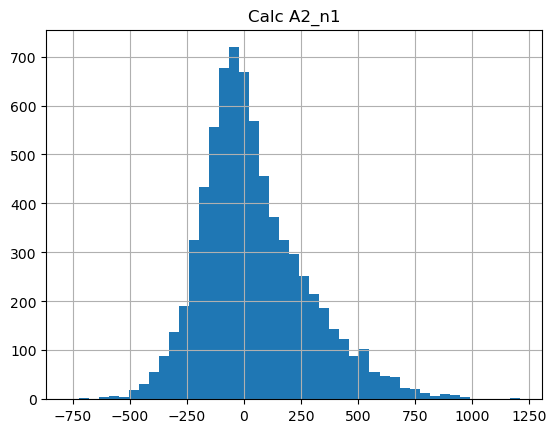

In [11]:
df.hist(column_to_test, bins=45)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#df_test1 = principalDf - This one
df_test1 = df[['bpm', 'Calc A2', 'ws', 
                 'KP_Conf_Dif', 'X.Poss', 'Year_dif',  'Calc A', 'Calc B', 'Calc A3', 
                 'DR.',  'Team_AdjEM_dif', 'player_type', 'Contribution_n1',
                 'Class', 'Calc C', 'ORtg',
                 'Calc_Overall_n1_Contr', 
                 'per', 'efg_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'usg_pct', 'tov_pct', 'Calc Overall A', 'Calc Overall A2', 'Calc Overall A3']]
#df_test1 = df_test1.reset_index() 'Calc Overall A', 'Calc Overall A2', 'Calc Overall A3',
columns = list(df_test1.columns)
columns.remove('Contribution_n1')

# #columns.remove('Calc_Overall_Contr'),
columns.remove('Calc_Overall_n1_Contr')
# # PCA
# from sklearn.preprocessing import StandardScaler
# #y_try = df[['Calc_Overall_n1_Contr']]
# y_try = df_test1[['Contribution_n1']]
# df_temp = df_test1
# #print(df_temp.columns)
# df_temp = df_temp.drop(['Calc_Overall_n1_Contr', 'Contribution_n1'], axis=1)
# #df_temp = df_temp.drop(['Contribution_n1'], axis=1)
# x_try = df_temp.loc[:, columns].values
# #y_try = df.loc[:,['target']].values

# x_try = StandardScaler().fit_transform(x_try)

# from sklearn.decomposition import PCA

# pca = PCA(n_components=0.9, whiten=True)

# principalComponents = pca.fit_transform(x_try)

# principalDf = pd.DataFrame(data = principalComponents)
# principalDf.columns = principalDf.columns.astype(str)
# print(principalDf.shape)
# principalDf = pd.merge(principalDf, df_test1['player_type'],  left_index=True, right_index=True, how='left')
# print(principalDf.shape)
# 'games', 'games_started', 'Calc A', 'Calc B', 'ast_per_poss', 'pts_per_poss', 'Ht', 'Wt', 'stl_per_poss', 'blk_per_poss', , ,
#df_test1 = df_test1[df_test1['player_type']==0],
# 'Calc Overall', 'Calc_Overall_Contr',
#'player_type', 'KP_Rk_Dif', 'ORtg', 'X.Min',,
#'Team_AdjEM_dif', 'X.Min_n1', 'X.Poss_n1',,
#df_test1 = df_test1[df_test1['player_type']==0],
#columns = list(df_test1.columns)

columns.remove('player_type')
columns.remove('Calc A2')

#,
keep_col = ['player_type', 'Calc A2'] #- This one
#keep_col = []
#rem_columns = list(principalDf.columns)
rem_columns = columns
check = True
accuracy_end = 0
while len(rem_columns)>0 and check == True:
    acc_check = 0

    for col in rem_columns:
        if col=='player_type': continue
        X = df_test1[keep_col + [col]]
    # X = df_test1[['player_type', 'X.Poss', 'X.Min', 'X.Min_n1', 'ORtg', ,
    #                       'Year_dif', 'stl_per_poss', 'blk_per_poss', ,
    #                       'DR.', 'KP_Rk_Dif', 'Calc A']],
        #y = principalDf[['Contribution_n1']]
        y = df_test1[['Calc_Overall_n1_Contr']]
        #y = y_try
        #y = df_test1[['Contribution_n1']],
        # Model,
        seed = 7
        test_size = 0.18
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        
        # Random Forrest
        # model = RandomForestClassifier()
        # model.fit(X_train, y_train)

        # Naive-Bayes
        # model = GaussianNB()
        # model.fit(X_train, y_train)
        #model.
        # Nearest Neighbors
        # model = neighbors.KNeighborsClassifier()
        # model.fit(X_train, y_train)

        # Support Vector Machine
        # model = svm.SVC(kernel='linear')
        # model.fit(X_train, y_train)
        
        # Gradient Boosting Classifier
        model = GradientBoostingClassifier()
        model.fit(X_train, y_train)

        # folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
        # scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=folds)
        # accuracy = (sum(scores)/len(scores))
        #scores
        # Find Accuracy,

        accuracy = model.score(X_test, y_test) #- this one

        # y_pred = model.predict(X_test),
        # predictions = [round(value) for value in y_pred],
        # accuracy = accuracy_score(y_test, predictions),
        print(keep_col + [col])
        print('Accuracy: ', accuracy * 100)
        if accuracy > acc_check:
            acc_check = accuracy
            col_to_add = col
            check = True
    #print(\Adding: \, col_to_add),
    
    #print(\Rem Columns: \, rem_columns),
    #keep_col = keep_col + [col_to_add],
    if accuracy_end < acc_check:
        print('Adding: ', col_to_add)
        print('Rem Columns: ', rem_columns)
        accuracy_end = acc_check
        print('Accuracy: ', accuracy_end * 100)
        rem_columns.remove(col_to_add)
        keep_col = keep_col + [col_to_add]
    else:
        print('Fails', accuracy_end, acc_check)
        check = False
    print(keep_col)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'bpm']
Accuracy:  70.06854531607006


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ws']
Accuracy:  69.3069306930693


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'KP_Conf_Dif']
Accuracy:  70.14470677837015


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'X.Poss']
Accuracy:  70.22086824067021


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Year_dif']
Accuracy:  69.61157654226962


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc A']
Accuracy:  69.53541507996952


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc B']
Accuracy:  69.61157654226962


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc A3']
Accuracy:  70.14470677837015


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'DR.']
Accuracy:  69.84006092916985


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Team_AdjEM_dif']
Accuracy:  69.91622239146992


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Class']
Accuracy:  69.15460776846916


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc C']
Accuracy:  69.15460776846916


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg']
Accuracy:  70.6016755521706


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'per']
Accuracy:  69.76389946686976


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'efg_pct']
Accuracy:  68.92612338156893


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'fta_per_fga_pct']
Accuracy:  69.84006092916985


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'pprod']
Accuracy:  69.6877380045697


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'orb_pct']
Accuracy:  70.06854531607006


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'usg_pct']
Accuracy:  69.61157654226962


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'tov_pct']
Accuracy:  69.61157654226962


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A']
Accuracy:  69.45925361766946


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A2']
Accuracy:  69.07844630616908


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall A3']
Accuracy:  69.99238385377
Adding:  ORtg
Rem Columns:  ['bpm', 'ws', 'KP_Conf_Dif', 'X.Poss', 'Year_dif', 'Calc A', 'Calc B', 'Calc A3', 'DR.', 'Team_AdjEM_dif', 'Class', 'Calc C', 'ORtg', 'per', 'efg_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'usg_pct', 'tov_pct', 'Calc Overall A', 'Calc Overall A2', 'Calc Overall A3']
Accuracy:  70.6016755521706
['player_type', 'Calc A2', 'ORtg']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'bpm']
Accuracy:  70.67783701447068


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'ws']
Accuracy:  70.06854531607006


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif']
Accuracy:  71.28712871287128


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'X.Poss']
Accuracy:  69.84006092916985


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'Year_dif']
Accuracy:  70.83015993907082


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'Calc A']
Accuracy:  69.91622239146992


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'Calc B']
Accuracy:  70.29702970297029


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'Calc A3']
Accuracy:  70.14470677837015


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'DR.']
Accuracy:  70.52551408987053


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'Team_AdjEM_dif']
Accuracy:  70.83015993907082


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'Class']
Accuracy:  69.84006092916985


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'Calc C']
Accuracy:  69.84006092916985


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'per']
Accuracy:  70.44935262757045


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'efg_pct']
Accuracy:  69.84006092916985


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'fta_per_fga_pct']
Accuracy:  70.98248286367098


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'pprod']
Accuracy:  69.99238385377


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'orb_pct']
Accuracy:  70.67783701447068


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'usg_pct']
Accuracy:  69.76389946686976


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'tov_pct']
Accuracy:  70.52551408987053


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'Calc Overall A']
Accuracy:  69.91622239146992


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'Calc Overall A2']
Accuracy:  69.99238385377


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'Calc Overall A3']
Accuracy:  70.44935262757045
Adding:  KP_Conf_Dif
Rem Columns:  ['bpm', 'ws', 'KP_Conf_Dif', 'X.Poss', 'Year_dif', 'Calc A', 'Calc B', 'Calc A3', 'DR.', 'Team_AdjEM_dif', 'Class', 'Calc C', 'per', 'efg_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'usg_pct', 'tov_pct', 'Calc Overall A', 'Calc Overall A2', 'Calc Overall A3']
Accuracy:  71.28712871287128
['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'bpm']
Accuracy:  71.21096725057122


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'ws']
Accuracy:  71.43945163747144


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'X.Poss']
Accuracy:  71.28712871287128


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'Year_dif']
Accuracy:  71.66793602437167


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'Calc A']
Accuracy:  71.66793602437167


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'Calc B']
Accuracy:  70.83015993907082


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'Calc A3']
Accuracy:  71.74409748667175


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'DR.']
Accuracy:  71.13480578827114


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'Team_AdjEM_dif']
Accuracy:  70.83015993907082


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'Class']
Accuracy:  71.59177456207159


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'Calc C']
Accuracy:  71.28712871287128


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'per']
Accuracy:  71.36329017517137


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'efg_pct']
Accuracy:  70.37319116527037


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'fta_per_fga_pct']
Accuracy:  71.51561309977151


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'pprod']
Accuracy:  70.98248286367098


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct']
Accuracy:  71.82025894897181


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'usg_pct']
Accuracy:  71.13480578827114


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'tov_pct']
Accuracy:  71.13480578827114


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'Calc Overall A']
Accuracy:  71.13480578827114


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'Calc Overall A2']
Accuracy:  70.14470677837015


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'Calc Overall A3']
Accuracy:  71.05864432597106
Adding:  orb_pct
Rem Columns:  ['bpm', 'ws', 'X.Poss', 'Year_dif', 'Calc A', 'Calc B', 'Calc A3', 'DR.', 'Team_AdjEM_dif', 'Class', 'Calc C', 'per', 'efg_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'usg_pct', 'tov_pct', 'Calc Overall A', 'Calc Overall A2', 'Calc Overall A3']
Accuracy:  71.82025894897181
['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'bpm']
Accuracy:  72.2010662604722


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'ws']
Accuracy:  72.35338918507236


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'X.Poss']
Accuracy:  71.13480578827114


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Year_dif']
Accuracy:  71.82025894897181


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A']
Accuracy:  71.8964204112719


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc B']
Accuracy:  72.2010662604722


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3']
Accuracy:  72.5057121096725


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'DR.']
Accuracy:  71.21096725057122


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Team_AdjEM_dif']
Accuracy:  71.28712871287128


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Class']
Accuracy:  71.74409748667175


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc C']
Accuracy:  71.66793602437167


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'per']
Accuracy:  71.66793602437167


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'efg_pct']
Accuracy:  71.59177456207159


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'fta_per_fga_pct']
Accuracy:  72.04874333587205


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'pprod']
Accuracy:  71.74409748667175


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'usg_pct']
Accuracy:  71.21096725057122


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'tov_pct']
Accuracy:  72.12490479817212


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc Overall A']
Accuracy:  72.27722772277228


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc Overall A2']
Accuracy:  71.36329017517137


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc Overall A3']
Accuracy:  71.59177456207159
Adding:  Calc A3
Rem Columns:  ['bpm', 'ws', 'X.Poss', 'Year_dif', 'Calc A', 'Calc B', 'Calc A3', 'DR.', 'Team_AdjEM_dif', 'Class', 'Calc C', 'per', 'efg_pct', 'fta_per_fga_pct', 'pprod', 'usg_pct', 'tov_pct', 'Calc Overall A', 'Calc Overall A2', 'Calc Overall A3']
Accuracy:  72.5057121096725
['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3', 'bpm']
Accuracy:  72.5057121096725


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3', 'ws']
Accuracy:  71.66793602437167


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3', 'X.Poss']
Accuracy:  71.74409748667175


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3', 'Year_dif']
Accuracy:  72.5057121096725


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3', 'Calc A']
Accuracy:  71.74409748667175


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3', 'Calc B']
Accuracy:  71.66793602437167


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3', 'DR.']
Accuracy:  71.74409748667175


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3', 'Team_AdjEM_dif']
Accuracy:  71.28712871287128


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3', 'Class']
Accuracy:  71.74409748667175


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3', 'Calc C']
Accuracy:  71.21096725057122


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3', 'per']
Accuracy:  71.36329017517137


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3', 'efg_pct']
Accuracy:  70.52551408987053


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3', 'fta_per_fga_pct']
Accuracy:  71.82025894897181


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3', 'pprod']
Accuracy:  71.59177456207159


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3', 'usg_pct']
Accuracy:  71.59177456207159


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3', 'tov_pct']
Accuracy:  72.2010662604722


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3', 'Calc Overall A']
Accuracy:  71.59177456207159


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3', 'Calc Overall A2']
Accuracy:  71.28712871287128


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3', 'Calc Overall A3']
Accuracy:  71.51561309977151
Fails 0.725057121096725 0.725057121096725
['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3']


In [13]:
seed = 7
test_size = 0.18
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
#model_test = GaussianNB()
model_test = GradientBoostingClassifier()
#X_temp = df_test1[keep_col]
X_temp = df_test1[['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3']]
#X_temp.head(10)

y_temp = df_test1[['Calc_Overall_n1_Contr']]
X_train_check, X_test_check, y_train_check, y_test_check = train_test_split(X_temp, y_temp, test_size=test_size, random_state=seed)

model_test.fit(X_train_check, y_train_check)
model_test.score(X_test_check, y_test_check)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7242955064737243

In [14]:
from sklearn.metrics import classification_report
predictions = model_test.predict(X_test_check)
print(classification_report(y_test_check, predictions))

              precision    recall  f1-score   support

           0       0.72      0.48      0.57       149
           1       0.64      0.66      0.65       493
           2       0.79      0.83      0.81       671

    accuracy                           0.72      1313
   macro avg       0.71      0.65      0.68      1313
weighted avg       0.72      0.72      0.72      1313



In [19]:
beta_df = pd.read_csv("/Users/caldavis/Documents/GitHub/Capstone-project/Data folder/Prediction Names.csv")
beta_df = beta_df[['PLAYER_ID', 'KP Diff', 'Year Diff']]
beta_df = pd.merge(a, beta_df, left_on='PLAYER_ID', right_on='P')

,PLAYER_ID,KP Diff,Year Diff
0,cam-spencer-1,0.96,1
1,dalton-knecht-1,16.87,1
2,josh-cohen-1,20.32,1
3,jordan-king-1,8.83,1
4,sean-bairstow-1,-4.16,1
5,bradley-ezewiro-1,-8.85,1
6,jimmy-belljr-1,-3.76,1
7,isaiah-carr-1,-7.98,1
8,antoine-smithjr-1,6.96,1


In [18]:
pred = pd.DataFrame(predictions)
y_test_check = y_test_check.reset_index()
pred = pd.merge(pred, y_test_check, left_index=True, right_index=True)
pred

,0,index,Calc_Overall_n1_Contr
0,2,5845,1
1,2,6399,2
2,2,6093,2
3,1,2688,0
4,2,4485,2
...,...,...,...
1308,2,3045,1
1309,1,6598,1
1310,2,495,2
1311,2,1784,2


In [ ]:
print(accuracy_end, acc_check)

0.6058269065981148 0.6032562125107113


In [ ]:
output = pd.DataFrame(y_test['Calc_Overall_n1_Contr'])
output = output.rename(columns={'Calc_Overall_n1_Contr': 'Actual'})

# output = pd.DataFrame(y_test['Contribution_n1'])
# output = output.rename(columns={'Contribution_n1': 'Actual'})

output['Predictions'] = model.predict(X_test)
output3 = output.groupby('Predictions').count()
output['Better'] = np.where(output['Predictions']==output['Actual'], 1, 0)
output2 = output.groupby(['Predictions', 'Actual']).count()

output2

Better
Predictions Actual        
0           0           86
            1           59
            2            4
1           0           46
            1          355
            2          104
            3           21
2           0            3
            1          133
            2          210
            3           65
3           1           14
            2           30
            3           37

In [ ]:
# Final Execution
# print(rem_columns)
#final = rem_columns + ['Calc_Overall_n1_Contr']
# print(final)
#df_final = df[rem_columns.append('Calc_Overall_n1_Contr')]
df_final = df_test1[['player_type', 'Calc A2', 'Calc B', 'bpm', 'tov_pct', 'efg_pct', 'ws', 'Year_dif']]
print(df_final.columns)
#X_train_final = df_final[['player_type', 'Calc A2', 'tov_pct', 'pprod', 'Class', 'Team_AdjEM_dif', 'DR.', 'ORtg', 'Calc A', 'fta_per_fga_pct']]
X_train_final = df_test1[['player_type', 'Calc A2', 'ORtg', 'KP_Conf_Dif', 'orb_pct', 'Calc A3']]
y_train_final = df_test1[['Calc_Overall_n1_Contr']]
model_final = GradientBoostingClassifier()
#X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y, test_size=0, random_state=100)
model_final.fit(X_train_final, y_train_final)
folds = KFold(n_splits = 6, shuffle = True, random_state=7)
scores = cross_val_score(model_final, X_train_final, y_train_final, scoring='accuracy', cv=folds)
accuracy_final = (sum(scores)/len(scores))
print(scores)
print(accuracy_final)

Index(['player_type', 'Calc A2', 'Calc B', 'bpm', 'tov_pct', 'efg_pct', 'ws',
       'Year_dif'],
      dtype='object')


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

KeyboardInterrupt: 

In [16]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance

print(len(df.columns))
#y_try2 = df[['Contribution_n1']]
y_try2 = df_test1[['Calc_Overall_n1_Contr']]
print(len(y_try2.columns))
X_try2 = df_test1[['bpm', 'Calc A2', 'ws', 
                  'KP_Conf_Dif', 'X.Poss', 'Year_dif',  'Calc A', 'Calc B', 'Calc A3', 'Calc Overall A', 'Calc Overall A2', 'Calc Overall A3',
                  'DR.',  'Team_AdjEM_dif', 'player_type',
                  'Class', 'Calc C', 'ORtg', 'per', 'efg_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'usg_pct', 'tov_pct']]
#X_try2 = df[['player_type', 'Calc A2', 'tov_pct', 'pprod', 'Class', 'Team_AdjEM_dif', 'DR.', 'ORtg', 'Calc A', 'fta_per_fga_pct']]
print(len(X_try2.columns))



365
1
25


In [17]:

min_features_to_select = 1  # Minimum number of features to consider
clf = GradientBoostingClassifier()
cv = StratifiedKFold(6)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_try2, y_try2, test_size=test_size, random_state=seed)
rfecv = RFECV(
    estimator=clf,
    step=1,
    #cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
    # importance_getter=permutation_importance(clf, X_test3, y_test3).impo
)
rfecv.fit(X_try2, y_try2)

print(f"Optimal number of features: {rfecv.n_features_}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

KeyboardInterrupt: 

In [ ]:
rfecv.get_feature_names_out()

array(['bpm', 'Calc A2', 'ws', 'KP_Conf_Dif', 'X.Poss', 'Calc A',
       'Calc B', 'Calc A3', 'Calc Overall A', 'Calc Overall A2',
       'Calc Overall A3', 'DR.', 'Team_AdjEM_dif', 'Calc C', 'ORtg',
       'per', 'efg_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'usg_pct',
       'tov_pct'], dtype=object)

In [ ]:
max(list(rfecv.cv_results_['mean_test_score']))

0.6867361281521157

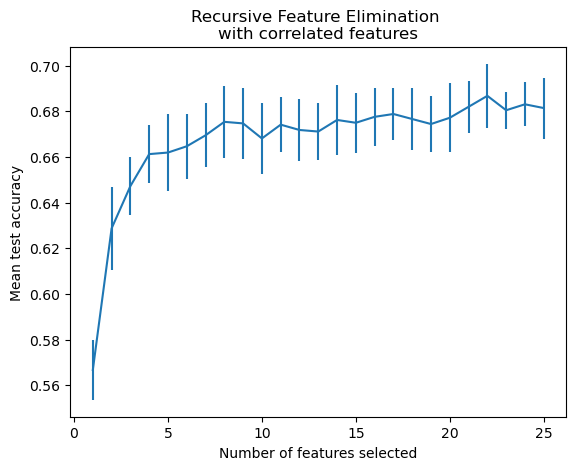

In [ ]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()